In [18]:
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


importing and orgenizing  data 


In [19]:
columns = [
    "ID", "Diagnosis",
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

df = pd.read_csv(r"C:/project_2year/wdbc.data", header=None, names=columns)


Cheaking the data

In [20]:
#Cheaking what the type of informetion we have.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   Diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [21]:
#Cheaking for missing valuse
missing_columns = df.isnull().sum()
missing_columns = missing_columns[missing_columns > 0]
if not missing_columns.empty:
        print("Missing values found in the following columns:")
        print(missing_columns)
else:
    print("No missing values found in any column.")



No missing values found in any column.


In [22]:
# Find duplicated IDs
duplicated_ids = df[df['ID'].duplicated(keep=False)]

# Check if any duplicates found
if not duplicated_ids.empty:
    print("Found duplicated ID numbers:")
    print(duplicated_ids.sort_values(by='ID'))
else:
    print("No duplicated ID numbers found.")

No duplicated ID numbers found.


drop diagnose and id colums

In [23]:
#cleanig the data 
data = df.drop(df.columns[[0, 1]], axis=1)



We chose to focus primarily on the third group, which illustrates the distribution of worst-case feature values between malignant and benign groups.
This decision is based on the clinical insight that cancer typically manifests in extreme and abnormal regions of the tissue rather than in its average structure.
Therefore, this plot is expected to provide more reliable and meaningful information, helping us identify a set of key features to focus on in the next steps of the analysis.
In addition to focusing on the worst-case feature values, we incorporated insights from the other two plots—based on the mean and standard error values—to reinforce and validate our conclusions.

In [24]:
def pick_columns(df,suffix):
 cols = [col for col in df.columns if col.endswith('_worst')]
 subset = df[cols]
 return subset

we create heatmap for the worst values

In [25]:
def heatmap(df, suffix):
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True, fmt=".2f",
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        robust=True,
        linewidths=0.5,
        square=True,
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f"Heatmap of {suffix} (corr range –1 to +1)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


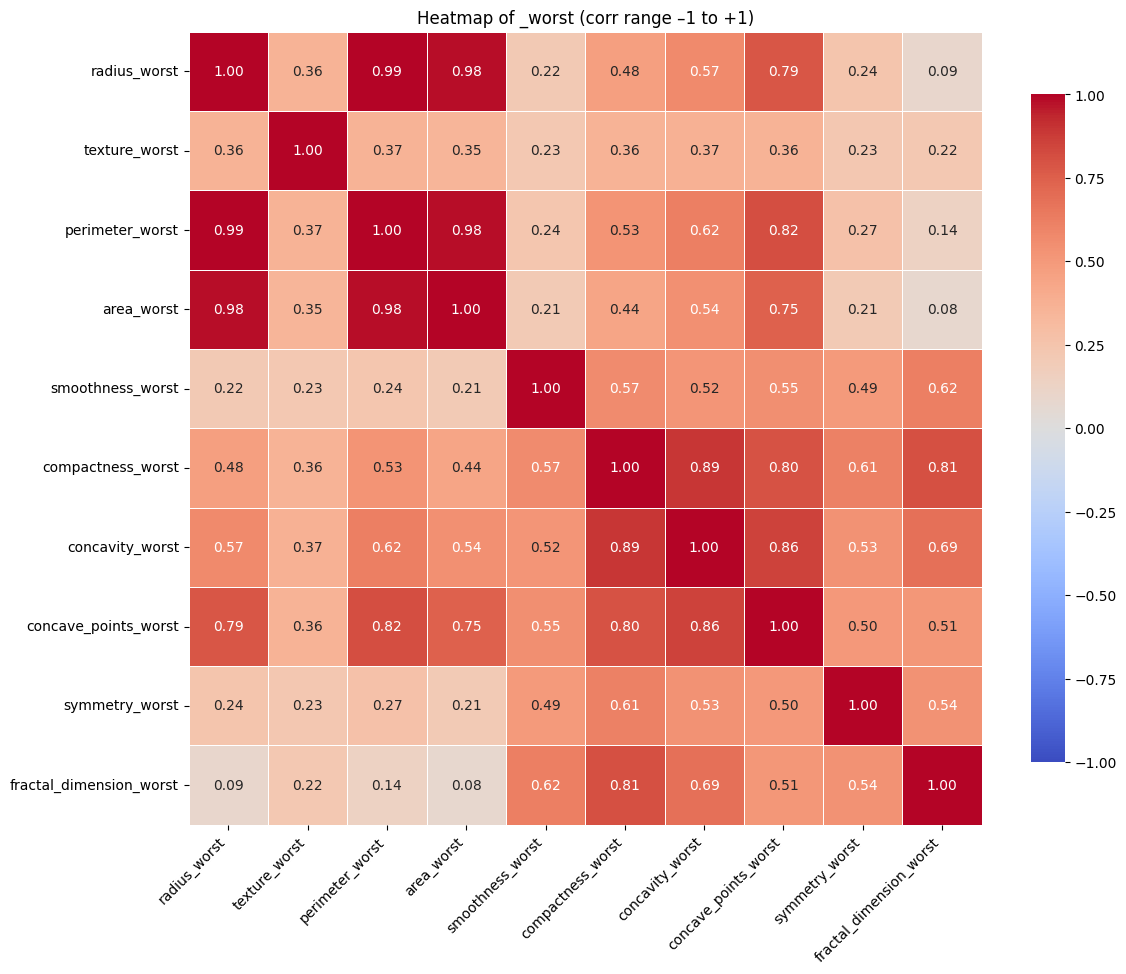

In [26]:
worst_col= pick_columns(data,'_worst')
heatmap(worst_col,'_worst')

Normalizing the data

In [27]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(worst_col)
normalized_worst_df = pd.DataFrame(normalized_data, columns=worst_col.columns)

# הדפסת התוצאה
print(normalized_worst_df.head())


   radius_worst  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0      1.886690      -1.359293         2.303601    2.001237          1.307686   
1      1.805927      -0.369203         1.535126    1.890489         -0.375612   
2      1.511870      -0.023974         1.347475    1.456285          0.527407   
3     -0.281464       0.133984        -0.249939   -0.550021          3.394275   
4      1.298575      -1.466770         1.338539    1.220724          0.220556   

   compactness_worst  concavity_worst  concave_points_worst  symmetry_worst  \
0           2.616665         2.109526              2.296076        2.750622   
1          -0.430444        -0.146749              1.087084       -0.243890   
2           1.082932         0.854974              1.955000        1.152255   
3           3.893397         1.989588              2.175786        6.046041   
4          -0.313395         0.613179              0.729259       -0.868353   

   fractal_dimension_worst  
0        

Now we want to choose 2-3 features so we create pairplot for the feature values to see wehere the varience is the highest 

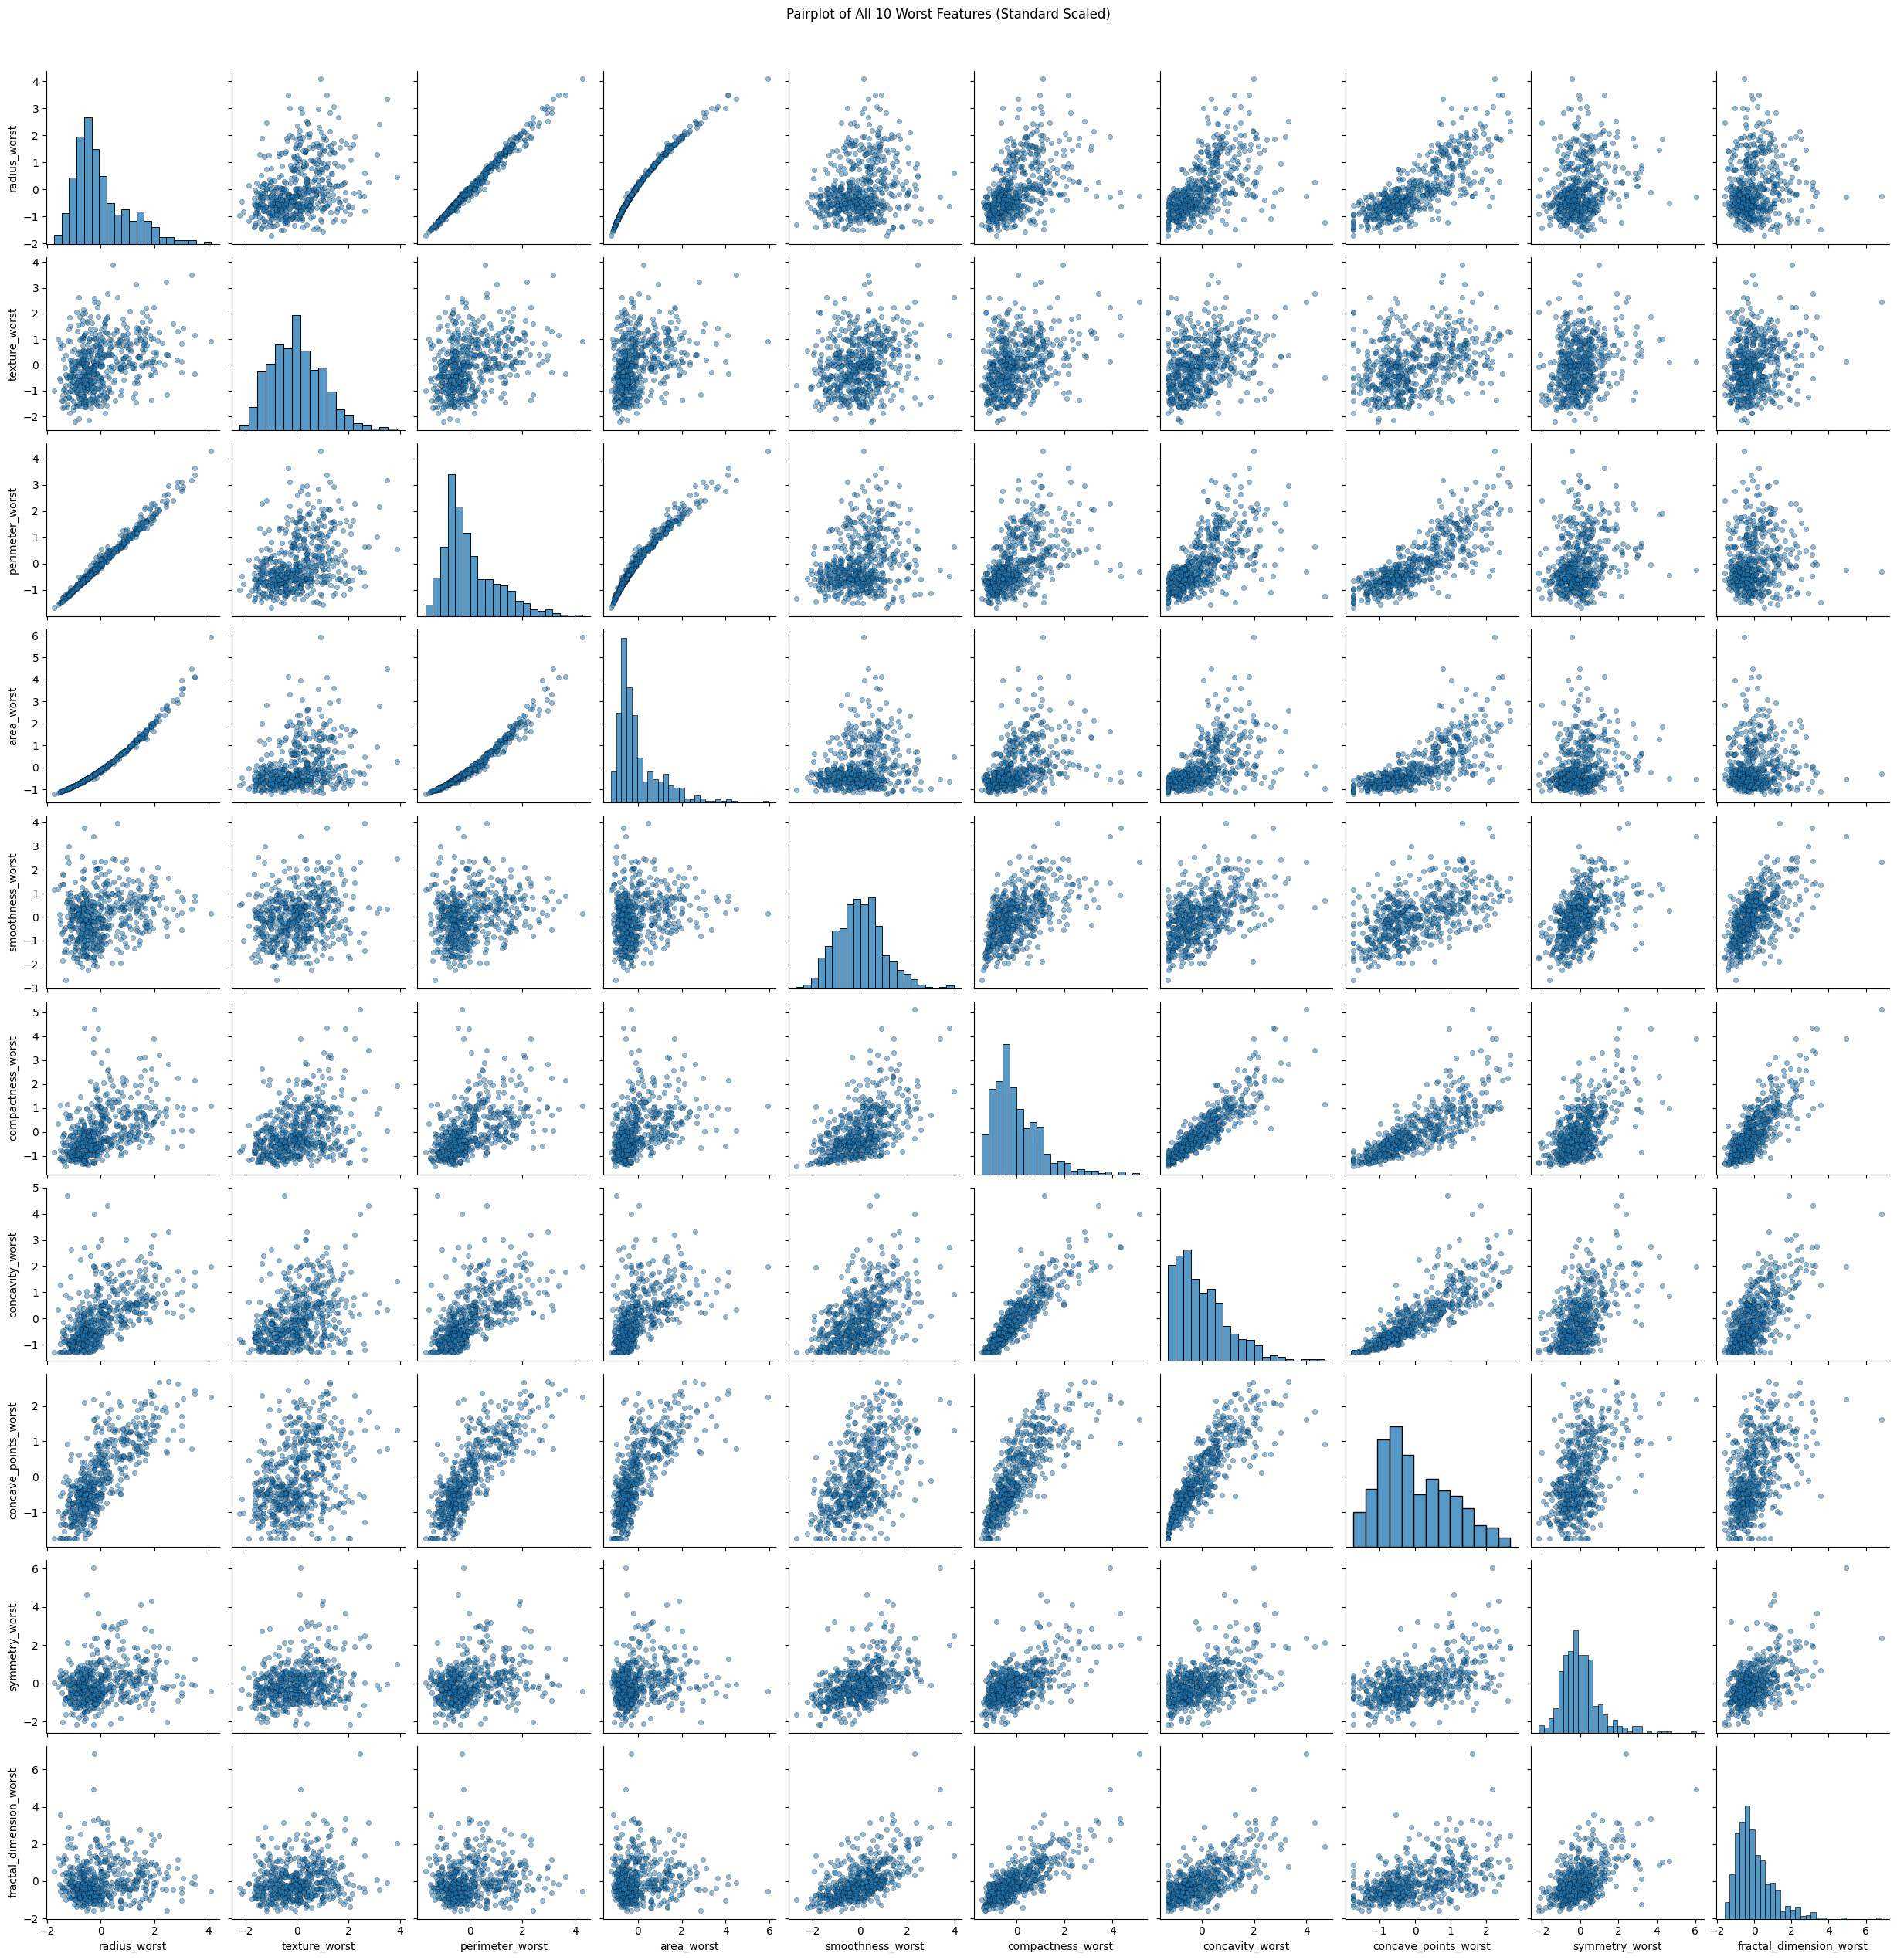

In [28]:
sns.pairplot(normalized_worst_df, plot_kws={"alpha": 0.5, "s": 20, "edgecolor": "k"})
plt.suptitle("Pairplot of All 10 Worst Features (Standard Scaled)", y=1.02)
plt.show()

מסקנות מגרף זה ומטבלת החום-ניתן להוריד מספר תכונות בגלל שיש בינהם מתאם גבוה.

pca מיוחד

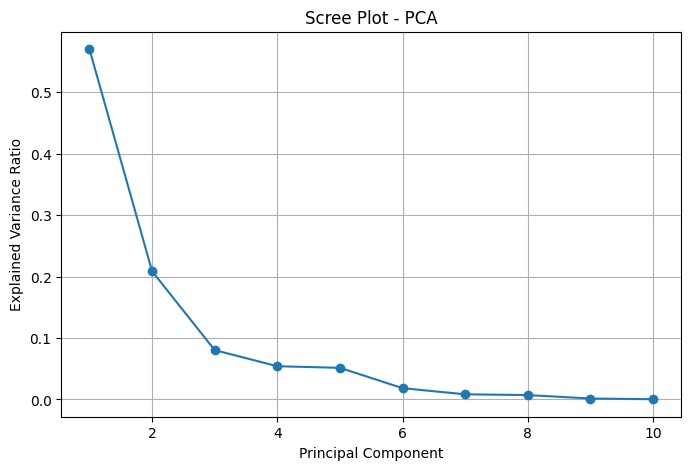

In [29]:
from sklearn.decomposition import PCA

# הפעלת PCA
pca = PCA()
pca.fit(normalized_worst_df)

# תרשים Scree
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - PCA')
plt.grid(True)
plt.show()


ניתן לראות מרפק ברור.  כעת נמצא מי הם 2-3 התכונות המרכזיות וכך נדע על איזה תכונות להפעיל את האלגו.

Loadings (השפעת כל תכונה על PC1 ו-PC2):
                              PC1       PC2
radius_worst             0.335910 -0.403137
texture_worst            0.200731 -0.042572
perimeter_worst          0.348151 -0.375518
area_worst               0.324739 -0.415256
smoothness_worst         0.248626  0.337870
compactness_worst        0.364568  0.250566
concavity_worst          0.374742  0.139085
concave_points_worst     0.397637 -0.041685
symmetry_worst           0.249753  0.308607
fractal_dimension_worst  0.254083  0.478495


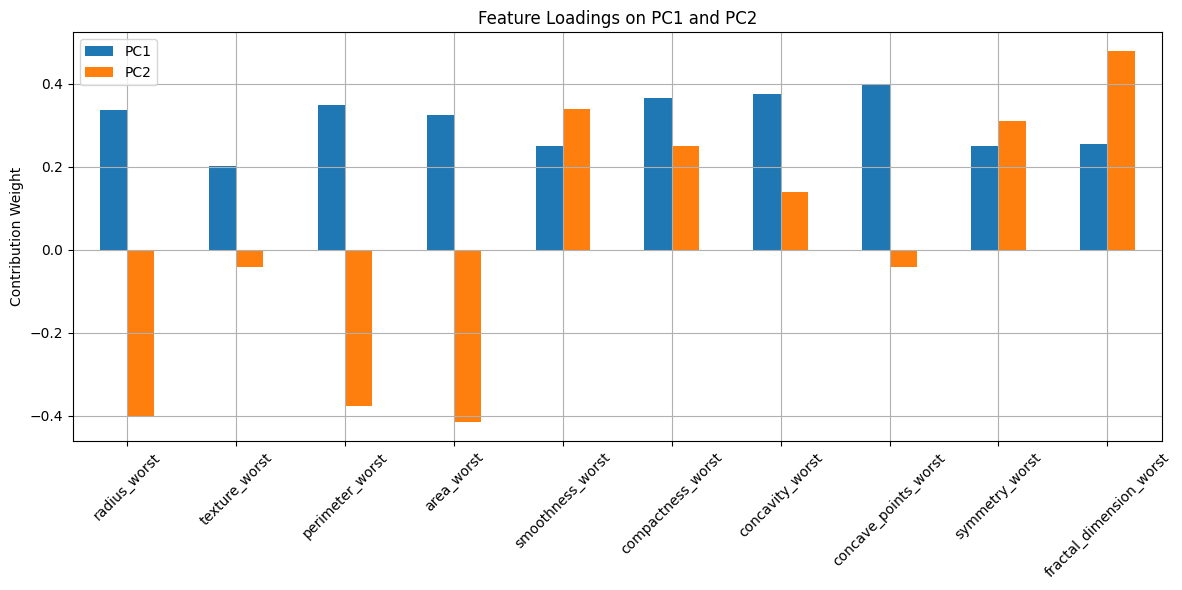

In [30]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# הרצת PCA על הדאטה המנורמל
pca = PCA(n_components=2)
pca.fit(normalized_worst_df)

# שליפת ה-loadings (השפעת כל תכונה על כל רכיב)
loadings = pd.DataFrame(pca.components_.T, 
                        index=normalized_worst_df.columns, 
                        columns=['PC1', 'PC2'])

# הדפסת הטבלה
print("Loadings (השפעת כל תכונה על PC1 ו-PC2):")
print(loadings)

# ציור גרף bar להשפעת כל תכונה על PC1 ו-PC2
loadings.plot(kind='bar', figsize=(12, 6))
plt.title("Feature Loadings on PC1 and PC2")
plt.ylabel("Contribution Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


כעת נבצע k-means רק עבור 3 תכונות- פרקטל, רדיוס, קונקייב פוינטס

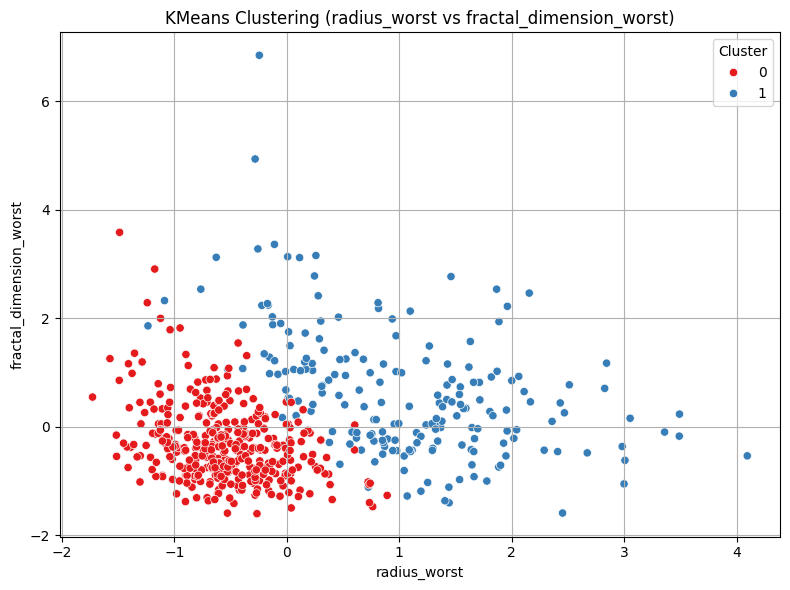

In [31]:



# בחירת שלוש תכונות לפי שמן המקורי
selected_features = ['radius_worst', 'fractal_dimension_worst', 'concave_points_worst']
selected_df = normalized_worst_df[selected_features]

# הרצת KMeans עם 2 אשכולות
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(selected_df)

# הוספת תווית האשכול לדאטה
selected_df_with_clusters = selected_df.copy()
selected_df_with_clusters['Cluster'] = clusters

# ציור גרף פיזור
plt.figure(figsize=(8, 6))
sns.scatterplot(data=selected_df_with_clusters,
                x='radius_worst', y='fractal_dimension_worst',
                hue='Cluster', palette='Set1')
plt.title("KMeans Clustering (radius_worst vs fractal_dimension_worst)")
plt.xlabel("radius_worst")
plt.ylabel("fractal_dimension_worst")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



כעת נבצע GMM

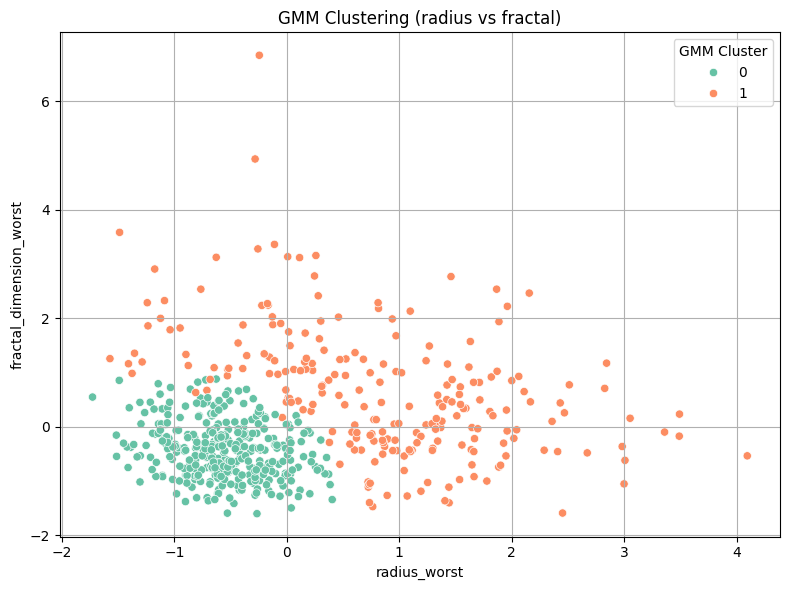

In [34]:


# בחירת התכונות
selected_features = ['radius_worst', 'fractal_dimension_worst', 'concave_points_worst']
selected_df = normalized_worst_df[selected_features]

# הפעלת GMM עם 2 רכיבים
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(selected_df)
gmm_labels = gmm.predict(selected_df)  # שיוך קשיח
gmm_probs = gmm.predict_proba(selected_df)  # הסתברות שייכות

# הוספת אשכול ל־DataFrame
selected_df_with_gmm = selected_df.copy()
selected_df_with_gmm['GMM_Cluster'] = gmm_labels

# ציור תוצאה
plt.figure(figsize=(8, 6))
sns.scatterplot(data=selected_df_with_gmm,
                x='radius_worst', y='fractal_dimension_worst',
                hue='GMM_Cluster', palette='Set2')
plt.title("GMM Clustering (radius vs fractal)")
plt.xlabel("radius_worst")
plt.ylabel("fractal_dimension_worst")
plt.grid(True)
plt.tight_layout()
plt.legend(title="GMM Cluster")
plt.show()


עוד תצורה מענייינת של אלגו זה-להסביר מה רואים.

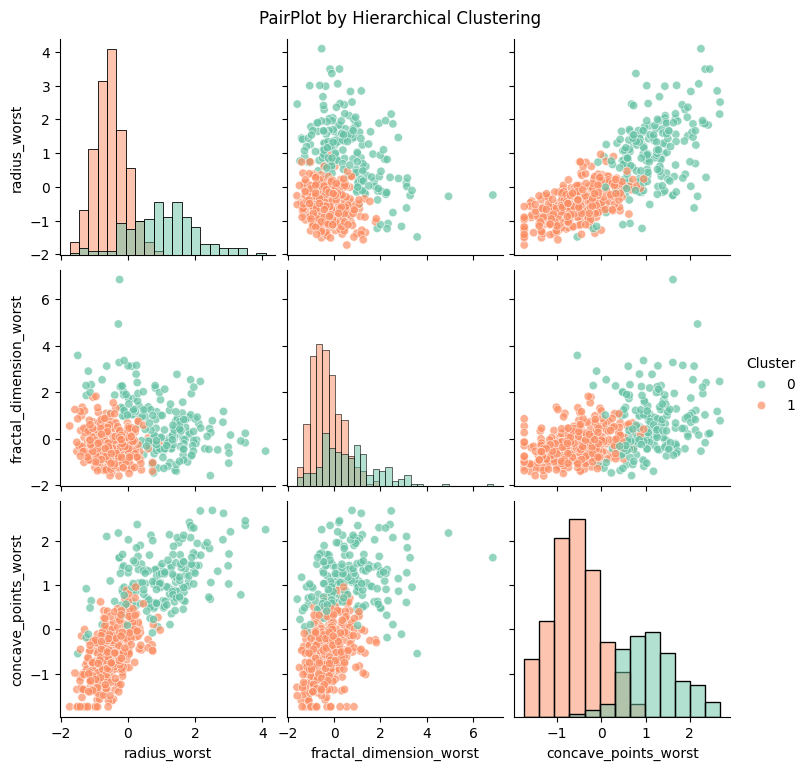

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# נוודא שכל הערכים מספריים
plot_df = selected_df.copy()
plot_df['Cluster'] = pd.to_numeric(hierarchical_labels)
plot_df['Diagnosis'] = df['Diagnosis']

# מציירים PairPlot רק עבור שלושת הפיצ’רים, לפי האשכול
sns.pairplot(
    plot_df,
    vars=['radius_worst', 'fractal_dimension_worst', 'concave_points_worst'],
    hue='Cluster',
    palette='Set2',
    diag_kind='hist',  # במקום kde כדי למנוע בעיות
    plot_kws={'alpha': 0.7}
)

plt.suptitle("PairPlot by Hierarchical Clustering", y=1.02)
plt.show()


Agglomerative Clustering

להוסיף השוואה עבור הקיימינס,עבור האלגו הזה- השוואה לדיאגוזה האמיתית 

In [36]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# מיפוי של תווית Diagnosis לתווית מספרית
df['Diagnosis_Num'] = df['Diagnosis'].map({'B': 0, 'M': 1})

# הוספת תוצאת GMM
df['GMM_Cluster'] = gmm_labels

# טבלת הצלבות רגילה
conf_mat = confusion_matrix(df['Diagnosis_Num'], df['GMM_Cluster'])

# טבלת הצלבות לאחר היפוך
conf_mat_flipped = confusion_matrix(df['Diagnosis_Num'], 1 - df['GMM_Cluster'])

# חישוב דיוקים
accuracy = (df['Diagnosis_Num'] == df['GMM_Cluster']).mean()
accuracy_flipped = (df['Diagnosis_Num'] == (1 - df['GMM_Cluster'])).mean()

# בדיקה מה עדיף
if accuracy > accuracy_flipped:
    best_conf_mat = conf_mat
    best_accuracy = accuracy
    note = "התאמה רגילה (לא הפוכה)"
else:
    best_conf_mat = conf_mat_flipped
    best_accuracy = accuracy_flipped
    note = "בוצע היפוך לקלאסטרים"

# הדפסה מסודרת
print("🔍 טבלת הצלבות בין GMM ל-Diagnosis:")
print(pd.DataFrame(best_conf_mat, index=['Benign (0)', 'Malignant (1)'], columns=['Cluster 0', 'Cluster 1']))
print(f"\n דיוק כולל: {best_accuracy:.2%}")
print(f" הערה: {note}")


🔍 טבלת הצלבות בין GMM ל-Diagnosis:
               Cluster 0  Cluster 1
Benign (0)           323         34
Malignant (1)         18        194

 דיוק כולל: 90.86%
 הערה: התאמה רגילה (לא הפוכה)


אלגו היררכי 

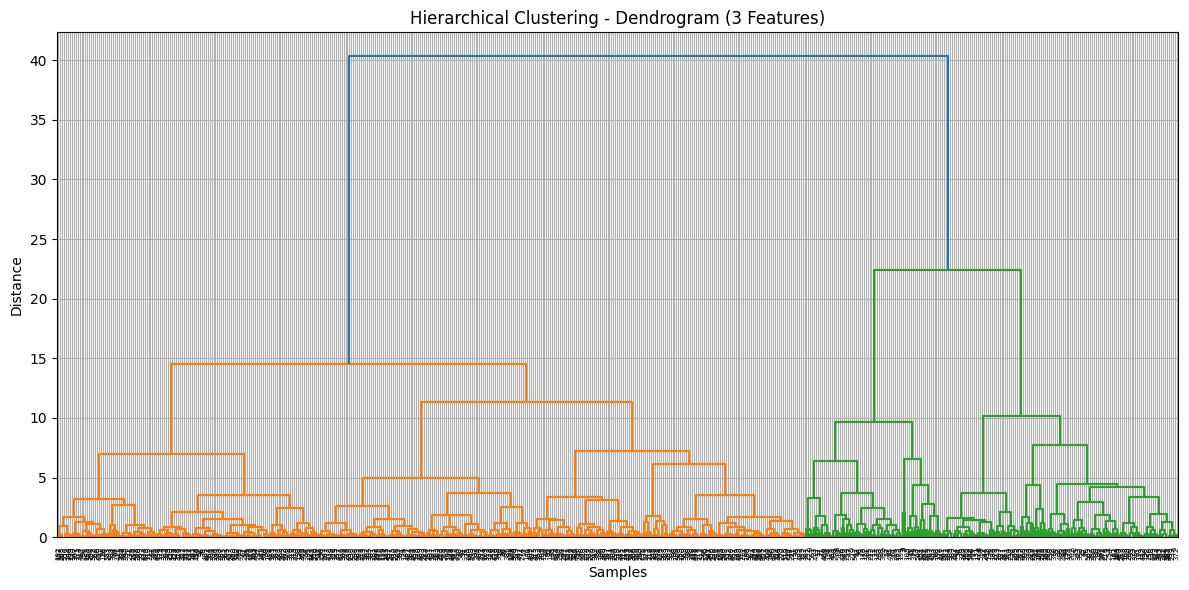

In [37]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# נניח ש-selected_df הוא ה-DataFrame עם שלושת הפיצ'רים המנורמלים:
# ['radius_worst', 'fractal_dimension_worst', 'concave_points_worst']

# יצירת מטריצת קישור (linkage matrix)
linkage_matrix = sch.linkage(selected_df, method='ward')

# ציור הדנדרוגרמה
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering - Dendrogram (3 Features)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.grid(True)
plt.tight_layout()
plt.show()


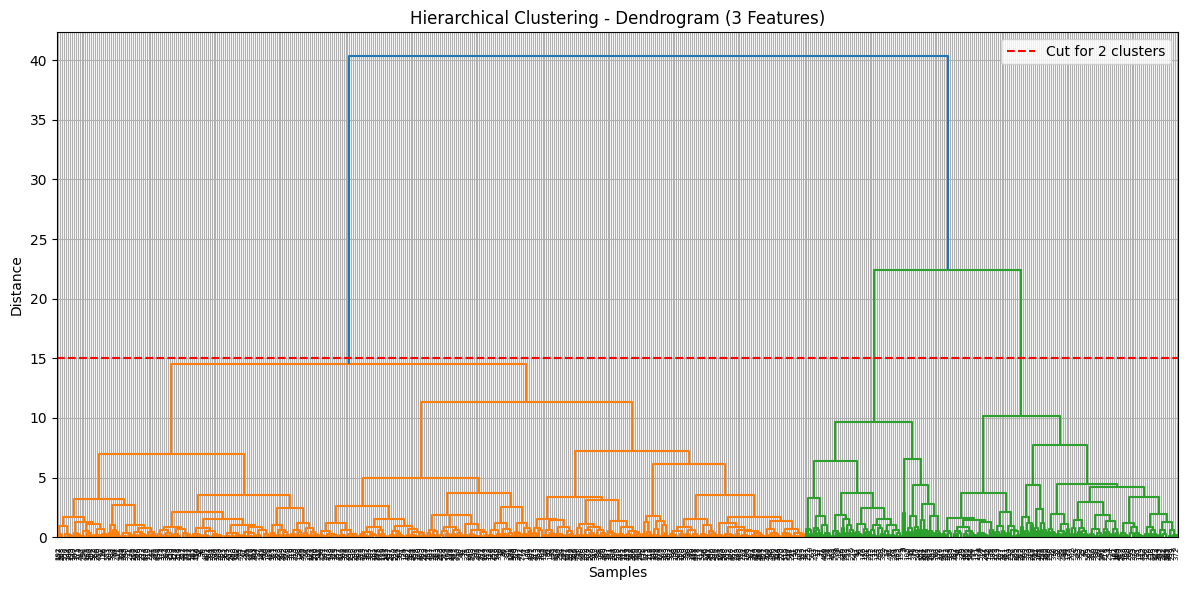

In [38]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# יצירת linkage matrix על שלושת הפיצ'רים
linkage_matrix = sch.linkage(selected_df, method='ward')

# ציור הדנדרוגרמה
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering - Dendrogram (3 Features)")
plt.xlabel("Samples")
plt.ylabel("Distance")

# קו אופקי לחיתוך ב-2 קבוצות
plt.axhline(y=15, color='red', linestyle='--', label='Cut for 2 clusters')  # תוכל לשנות את y לפי מה שנראה בדנדרוגרמה שלך

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score

# ניצור עמודה מספרית לאבחנה אם עדיין לא קיימת
if 'Diagnosis_Num' not in df.columns:
    df['Diagnosis_Num'] = df['Diagnosis'].map({'B': 0, 'M': 1})

# הרצת האלגוריתם ההיררכי על שלוש תכונות מנורמלות
hierarchical = AgglomerativeClustering(n_clusters=2)
hierarchical_labels = hierarchical.fit_predict(selected_df)

# חישוב דיוק רגיל והפוך
acc_normal = accuracy_score(df['Diagnosis_Num'], hierarchical_labels)
acc_flipped = accuracy_score(df['Diagnosis_Num'], 1 - hierarchical_labels)
best_accuracy = max(acc_normal, acc_flipped)

# טבלאות הצלבה רגילה והפוכה
conf_mat = confusion_matrix(df['Diagnosis_Num'], hierarchical_labels)
conf_mat_flipped = confusion_matrix(df['Diagnosis_Num'], 1 - hierarchical_labels)

# מדד ARI
ari = adjusted_rand_score(df['Diagnosis_Num'], hierarchical_labels)

# הצגת התוצאות
print("Confusion Matrix:")
print(conf_mat)
print("\nConfusion Matrix (flipped):")
print(conf_mat_flipped)
print(f"\nBest Accuracy: {best_accuracy * 100:.2f}%")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")




Confusion Matrix:
[[ 12 345]
 [177  35]]

Confusion Matrix (flipped):
[[345  12]
 [ 35 177]]

Best Accuracy: 91.74%
Adjusted Rand Index (ARI): 0.6942


להוסיף גרף שמראה את האלגו על כל 30 הפיצ'רים ועוד גרף רק על ה3 שבחרנו ולהראות שהחלוקה לא נפגעה.